In [2]:
pip install tensorflow

  Using cached tensorflow-2.9.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorboard-2.9.1-py3-none-any.whl (5.8 MB)
  Using cached grpcio-1.47.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.5 MB)
  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
  Using cached protobuf-3.19.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tensorflow_estimator-2.9.0-py2.py3-none-any.whl (438 kB)
  Using cached absl_py-1.2.0-py3-none-any.whl (123 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached libclang-14.0.6-py2.py3-none-manylinux2010_x86_64.whl (14.1 MB)
  Using cached tensorflow_io_gcs_f

In [12]:
import tensorflow as tf
import pandas as pd
import numpy as np
import boto3
from sagemaker import get_execution_role
import datetime
import matplotlib.pyplot as plt

In [4]:
role = get_execution_role()
bucket='bike-demand-forecast'
data_key = 'london_weather.csv'
data_location_1 = 's3://{}/{}'.format(bucket, 'london_weather.csv')
data_location_2 = 's3://{}/{}'.format(bucket, 'santander_daily_bike_demand_2010_202207.csv')

weather_data = pd.read_csv(data_location_1)
bike_demand = pd.read_csv(data_location_2)

In [5]:
bike_demand

,Day,Number of Bicycle Hires
0,30/7/2010,"6,897"
1,31/7/2010,"5,564"
2,1/8/2010,"4,303"
3,2/8/2010,"6,642"
4,3/8/2010,"7,966"
...,...,...
4380,27/7/2022,"39,282"
4381,28/7/2022,"43,096"
4382,29/7/2022,"41,584"
4383,30/7/2022,"42,718"


In [6]:
# tidying the raw input
bike_demand['daily_bicycle_hires'] = bike_demand['Number of Bicycle Hires'].apply(lambda x: int(x.replace(",","")))
bike_demand['day_of_date'] = bike_demand['Day'].apply(lambda x : int(x[:2] if x[2]=='/' else int(x[0])))
bike_demand['Day_2'] = bike_demand.apply(lambda x : x.Day[2:] if x.day_of_date < 10 else x.Day[3:] , axis = 1)
bike_demand['mth_of_date'] = bike_demand['Day_2'].apply(lambda x : int(x[:2] if x[2]=='/' else int(x[0])))
bike_demand['yr_of_date'] = bike_demand['Day_2'].apply(lambda x : int(x[-4:]))
bike_demand['date'] = bike_demand.apply(lambda x: datetime.datetime(x.yr_of_date,x.mth_of_date,x.day_of_date),axis=1)

bike_demand = bike_demand[['date','daily_bicycle_hires']]


In [7]:
bike_demand

,date,daily_bicycle_hires
0,2010-07-30,6897
1,2010-07-31,5564
2,2010-08-01,4303
3,2010-08-02,6642
4,2010-08-03,7966
...,...,...
4380,2022-07-27,39282
4381,2022-07-28,43096
4382,2022-07-29,41584
4383,2022-07-30,42718


### reusable functions

In [13]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

        for series_num in series:
        # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
        plt.plot(time[start:end], series[start:end], format)

        # Label the x-axis
        plt.xlabel("Time")

        # Label the y-axis
        plt.ylabel("Value")

        # Overlay a grid on the graph
        plt.grid(True)

        # Draw the graph on screen
        plt.show()

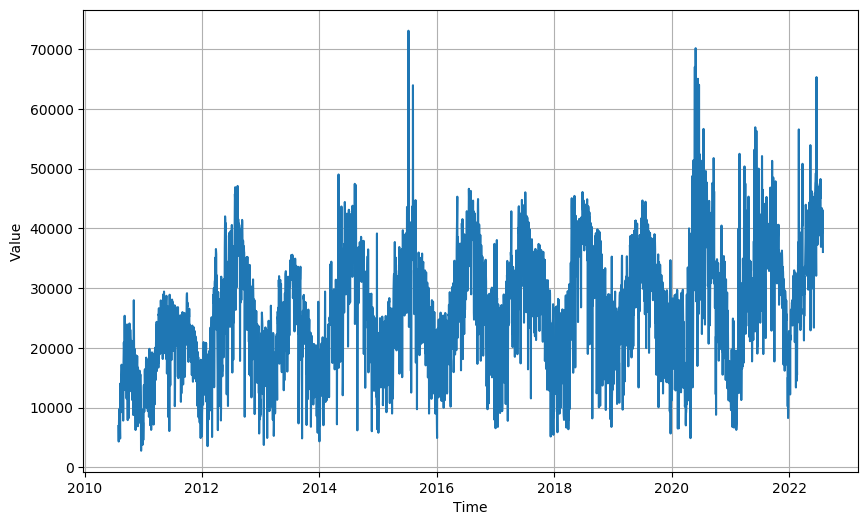

In [14]:
# initial visualisation
plot_series(bike_demand.date,bike_demand.daily_bicycle_hires)

It looks like there is no uptrend for bike demand except in the recent COVID-19 pandemic.

In [15]:
bike_demand[bike_demand.daily_bicycle_hires==bike_demand.daily_bicycle_hires.max()]

,date,daily_bicycle_hires
1805,2015-07-09,73094


The above date was a London Underground strike day and a working day (Thurs). The demand is probably explained by the WFH not being a trend in 2015 and it was a working day.

In [28]:
bike_demand['year'] = bike_demand['date'].apply(lambda x: x.year)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
demandByYearSum_df = bike_demand.groupby(by='year').sum()
demandByYearCount_df = bike_demand.groupby(by='year').count()
avgDemandByYear=pd.merge(demandByYearSum_df,demandByYearCount_df,how='inner',left_on='year',right_on='year')
avgDemandByYear['avg_demand']=avgDemandByYear.daily_bicycle_hires_x/avgDemandByYear.daily_bicycle_hires_y

In [41]:
avgDemandByYear.pop('date')

year
2010    155
2011    365
2012    366
2013    365
2014    365
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
2022    212
Name: date, dtype: int64

In [45]:
avgDemandByYear.set_axis(['sum_of_demand','sum_of_days','avg_demand'],axis=1, inplace=True)

In [46]:
avgDemandByYear

,sum_of_demand,sum_of_days,avg_demand
year,,,
2010,2180813,155,14069.761290
2011,7142449,365,19568.353425
2012,9519283,366,26008.969945
2013,8045459,365,22042.353425
2014,10023897,365,27462.731507
2015,9871839,365,27046.134247
2016,10303637,366,28152.013661
2017,10446044,365,28619.298630
2018,10567540,365,28952.164384


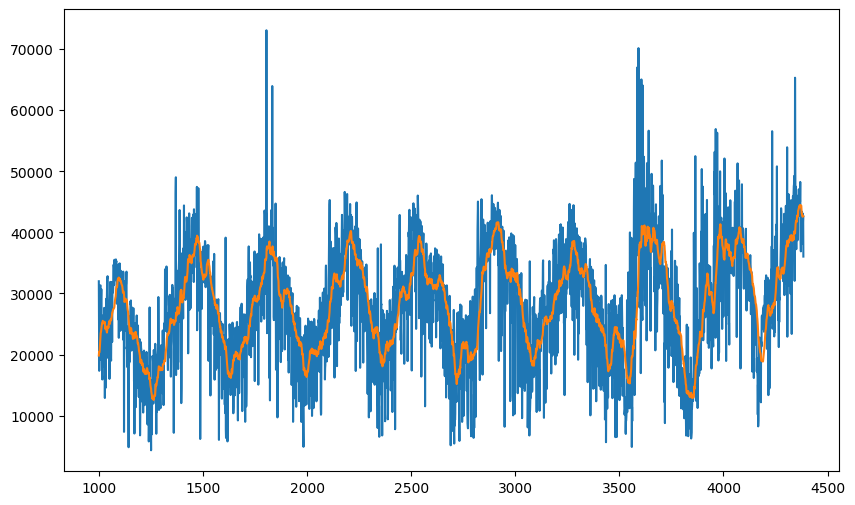

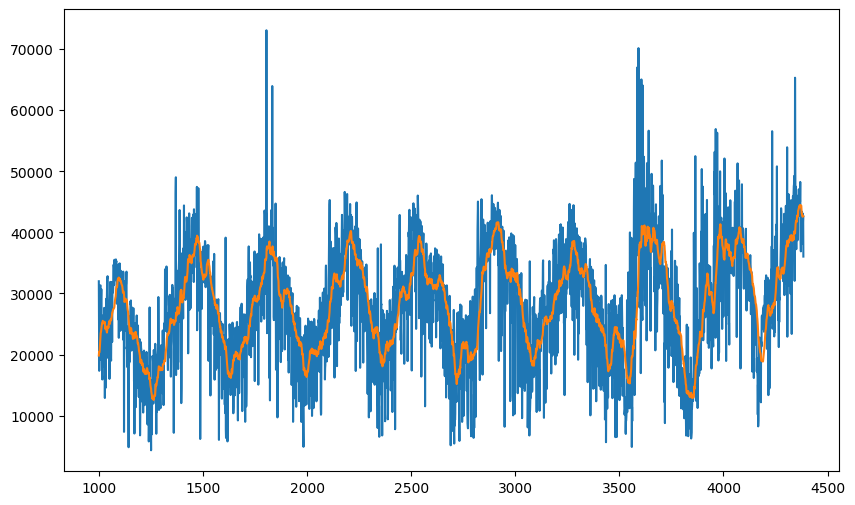

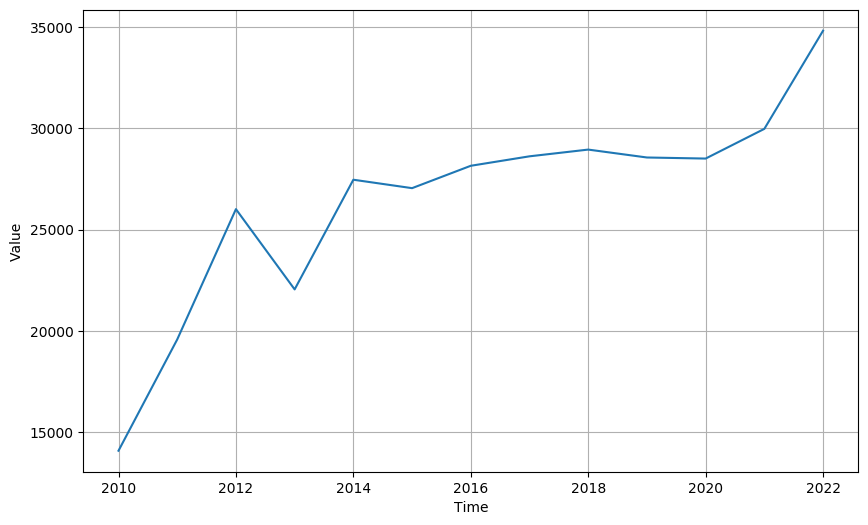

In [69]:
plot_series(avgDemandByYear.index,avgDemandByYear.avg_demand)

In [55]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = bike_demand.index.to_list()[:split_time]
x_train = bike_demand.daily_bicycle_hires[:split_time]

# Get the validation set
time_valid = bike_demand.index.to_list()[split_time:]
x_valid = bike_demand.daily_bicycle_hires[split_time:]

In [57]:
# Moving average
def moving_average_forecast(series, window_size):
    """Generates a moving average forecast

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to compute the average for

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Initialize a list
    forecast = []
    
    # Compute the moving average based on the window size
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    
    # Convert to a numpy array
    forecast = np.array(forecast)

    return forecast

In [74]:
# Generate the moving average forecast
moving_avg = moving_average_forecast(bike_demand.daily_bicycle_hires, 30)[split_time - 30:]

# Plot the results
plot_series(time_valid, (x_valid, moving_avg))

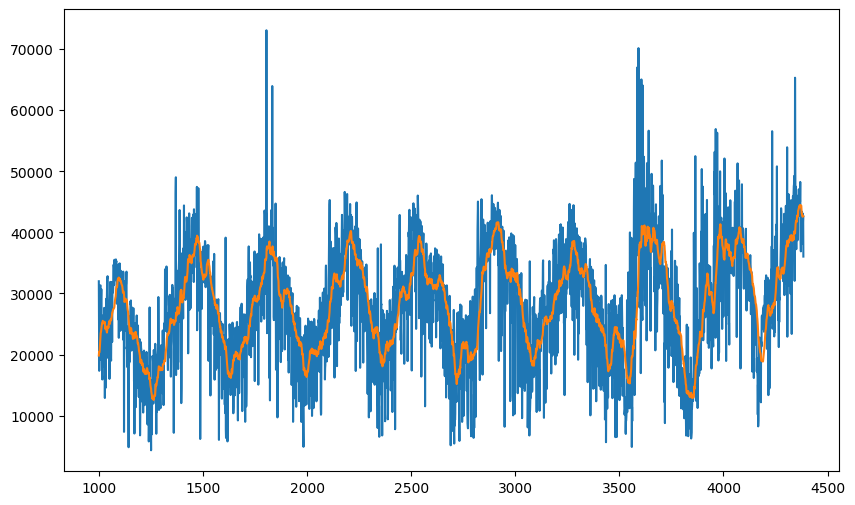

In [75]:
plt.show()

In [73]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

47516760.07113047
5223.461654357459
